In [1]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis


from UNSWNB15.analysis.features import first_level_features
from UNSWNB15.dataset import UNSWNB15

from scripts.models.pytorch.MLP import NetworkIntrusionMLP
from scripts.models.pytorch.CNN import NetworkIntrustionCNN
from scripts.models.pytorch.LSTM import NetworkIntrusionLSTM
from NIDS_attacks.substitut import attack_substitut
from NIDS_attacks.fgsm import attack_fgsm
from scripts.models.pytorch.train import train
from scripts.models.pytorch.visualization import display_loss
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(log_dir=f"{root_dir}/logs", log_name="TDM")
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")

c:\Users\valen\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-25 23:58:41,829 - INFO - Logger initialized for 'TDM_20251125_235841'


In [2]:
logger = LoggerManager(log_name="rf_notebook").get_logger()
logger.info("Starting Random Forest training notebook")

dataset = UNSWNB15(dataset_size="small", logger=logger)

dataset = dataset.optimize_memory()
cols = dataset.data.columns.tolist()
dataset = dataset.encode()
dataset = dataset.scale().subset(size=50000, multi_class=False)

2025-11-25 23:58:47,021 - INFO - Starting Random Forest training notebook
2025-11-25 23:58:47,024 - INFO - Downloading dataset: mrwellsdavid/unsw-nb15
2025-11-25 23:58:56,275 - INFO - Loaded UNSW-NB15_1.csv with shape: (700000, 46)
2025-11-25 23:58:56,296 - INFO - DataFrame shape: (700000, 46)
2025-11-25 23:58:56,297 - INFO - Initial dimensions: 700,000 rows x 46 columns = 32,200,000 cells
2025-11-25 23:59:02,003 - INFO - ============================================================
2025-11-25 23:59:02,004 - INFO - Preprocessing completed successfully
2025-11-25 23:59:02,006 - INFO - Final dimensions: 640,658 rows x 46 columns
2025-11-25 23:59:02,007 - INFO - Total rows removed: 59,342 (8.48%)
2025-11-25 23:59:02,008 - INFO - data retention rate: 91.52%
2025-11-25 23:59:02,009 - INFO - ============================================================
2025-11-25 23:59:02,167 - INFO - Optimizing memory usage of the dataset...
2025-11-25 23:59:02,183 - INFO - Initial memory usage: 229.73 MB
202

In [3]:
X_train, X_test, y_train, y_test = dataset.split(test_size=0.2, apply_smote=True)
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

2025-11-25 23:59:21,651 - INFO - Splitting dataset into training and testing sets...
2025-11-25 23:59:21,705 - INFO - Class distribution before SMOTE:
2025-11-25 23:59:25,754 - INFO - Applied SMOTE to balance the training set.
2025-11-25 23:59:25,756 - INFO - Class distribution after SMOTE:
2025-11-25 23:59:25,757 - INFO -   Class 0.0: 19992 samples
2025-11-25 23:59:25,758 - INFO -   Class 1.0: 19992 samples


Train set shape: (39984, 45)
Test set shape: (7856, 45)


In [4]:
from scripts.models.random_forest.random_forest import train_random_forest
# Train Random Forest using standalone function and plot CV scores
logger.info("Training Random Forest with cross-validation using train_random_forest...")
rf_model, cv_scores = train_random_forest(
    X_train,
    y_train,
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=0,
    cv=5,
    class_weight=None,
    logger=None
)
if cv_scores!= None:
    print("\n" + "="*50)
    print("CROSS-VALIDATION RESULTS")
    print("="*50)
    print(f"CV Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    # Plot CV scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cv_scores)+1), cv_scores, marker='o', markersize=10, linewidth=2, color='green')
    plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', 
                label=f'Mean: {cv_scores.mean():.4f}')
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Decision Tree Cross-Validation Scores', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

2025-11-25 23:59:26,615 - INFO - Training Random Forest with cross-validation using train_random_forest...


2025-11-25 23:59:33,597 - INFO - Running analysis for scikit-learn model: RandomForest


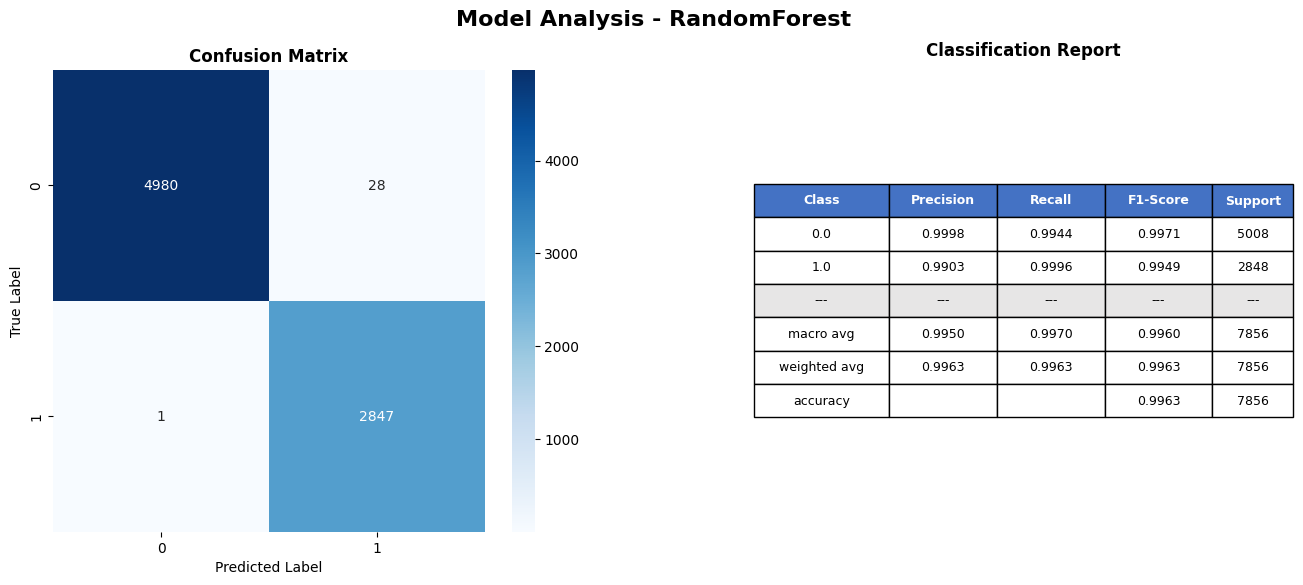

In [5]:
# Evaluate model
cm_rf, cr = perform_model_analysis(
    model=rf_model,
    X_test=X_test,
    y_test=y_test,
    logger=logger,
    model_name="RandomForest",
    dir=os.getcwd(),
    plot=True
)

2025-11-25 23:59:36,017 - INFO - Top 15 most important features:
2025-11-25 23:59:36,018 - INFO - 1. ct_state_ttl: 0.2377
2025-11-25 23:59:36,020 - INFO - 2. sttl: 0.2085
2025-11-25 23:59:36,021 - INFO - 3. Bwd Packets/s: 0.1022
2025-11-25 23:59:36,022 - INFO - 4. Avg Bwd Segment Size: 0.0693
2025-11-25 23:59:36,023 - INFO - 5. dttl: 0.0670
2025-11-25 23:59:36,024 - INFO - 6. Ltime: 0.0606
2025-11-25 23:59:36,025 - INFO - 7. tcprtt: 0.0419
2025-11-25 23:59:36,026 - INFO - 8. Stime: 0.0388
2025-11-25 23:59:36,028 - INFO - 9. ackdat: 0.0376
2025-11-25 23:59:36,029 - INFO - 10. Total Backward Packets: 0.0243
2025-11-25 23:59:36,030 - INFO - 11. synack: 0.0182
2025-11-25 23:59:36,032 - INFO - 12. state: 0.0166
2025-11-25 23:59:36,033 - INFO - 13. Flow Duration: 0.0140
2025-11-25 23:59:36,035 - INFO - 14. Total Length of Bwd Packets: 0.0118
2025-11-25 23:59:36,038 - INFO - 15. Dintpkt: 0.0115


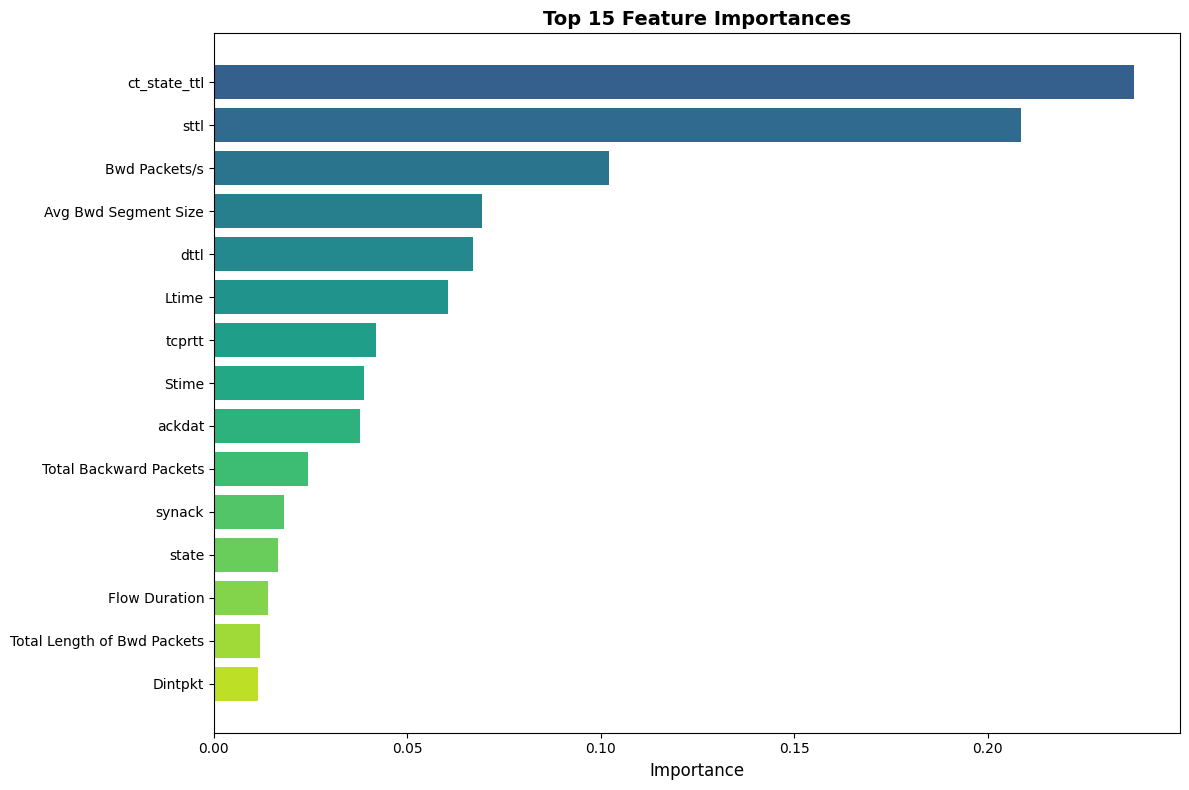

In [6]:
import numpy as np
from scripts.models.model_utils import (
    check_data_leakage,
    get_tree_feature_importance    
)

# Get feature importance
top_features = get_tree_feature_importance(
    rf_model,
    feature_names=list(dataset.data.columns),
    top_n=15,
    logger=logger
)

# Plot feature importance
features, importances = zip(*top_features)

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(features)))
plt.barh(range(len(features)), importances, color=colors)
plt.yticks(range(len(features)), features)
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
input_size = dataset.features.shape[1]
print(input_size)
print(X_test.shape)
num_classes = np.size(dataset.attack_classes[0])

45
(7856, 45)


2025-11-25 21:33:23,638 - INFO - Running analysis for scikit-learn model: Random Forest
c:\msys64\home\valen\TDpython\AdversarialNIDS\NIDS_attacks\substitut.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train  = torch.tensor(X_train, dtype=torch.float32).to(device)
c:\msys64\home\valen\TDpython\AdversarialNIDS\NIDS_attacks\substitut.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train  = torch.tensor(y_train, dtype=torch.long).to(device)
c:\msys64\home\valen\TDpython\AdversarialNIDS\NIDS_attacks\substitut.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), ra

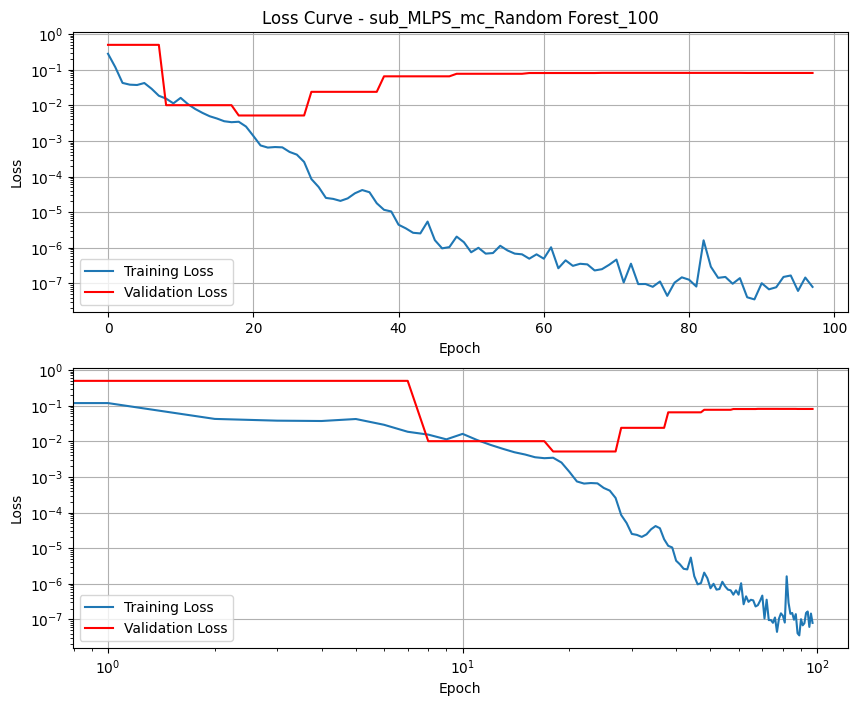

2025-11-25 21:33:58,227 - INFO - Running analysis for PyTorch model: sub_MLPS_mc_Random Forest_100 on device: cpu


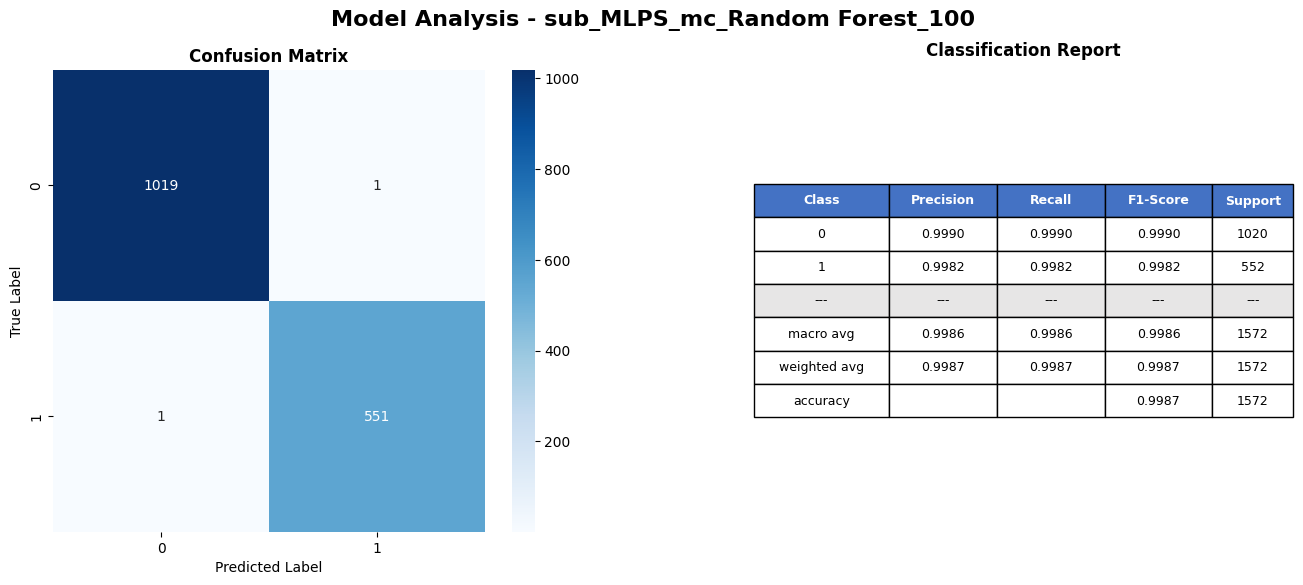

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
sub,cm,cr = attack_substitut(
    2,
    input_size=input_size,
    model=rf_model,
    X_test=X_test,
    y_test=y_test,
    dir=root_dir,
    logger=lm.logger,
    model_name="Random Forest",
    plot_analysis=True,
    plot_loss=True
    )

In [ ]:
first_level = features.first_level
attacked_features =  list(set(first_level) & set(features))
print(attacked_features)

TypeError: first_level_features() missing 1 required positional argument: 'self'

In [ ]:
dico_encoded = {col: cols.index(col) for col in cols}
print(dico_encoded)

Initial prediction on adversarial input: [[-17.638126  11.158567]] 1
Adversarial input after 69 iterations: [[ 0.21829526 -0.20661381]] 0


In [ ]:
indices = [dico_encoded[f] for f in attacked_features]

In [ ]:
from UNSWNB15.analysis.features import compute_features_batch
target = torch.zeros_like(y_test)
X_perturb = attack_fgsm(sub,nn.CrossEntropyLoss(),X_test,target,indices,eps=0.01)
for i in range(100):
    X_perturb = attack_fgsm(sub,nn.CrossEntropyLoss(),X_perturb,target,indices,eps=0.1)
with torch.no_grad():
    X_perturb = compute_features_batch(X_perturb,dico_encoded)